OUTTA AI 부트캠프 딥러닝반 - Diffusion Model

# **Diffusion Model 살펴보기**

### **1. PyTorch 라이브러리 임포트**

PyTorch 라이브러리를 임포트하고 사용 가능한 최적의 디바이스를 선택합니다.

(1) 먼저 Apple Silicon GPU (MPS)를 확인합니다.

(2) 다음으로 NVIDIA GPU (CUDA)를 확인합니다.

(3) 둘 다 사용할 수 없는 경우 CPU를 사용합니다.

In [1]:
import torch
import torch.nn as nn


if torch.backends.mps.is_available():
    my_device = torch.device('mps')
elif torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')


### **2. U-Net 아키텍처**

시간 정보를 고려한 U-Net 아키텍처를 아래와 같이 구현합니다.


In [2]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, track_running_stats = False),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, track_running_stats = False),
            nn.ReLU(),
        )


    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

        self.time_mlp = nn.Sequential(
                nn.Linear(time_dim, out_channels),
                nn.ReLU()
        )

    def forward(self, x, t):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)

        t = self.time_mlp(t)
        t = t.unsqueeze(-1).unsqueeze(-1)

        return (down_out+t, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(UpBlock, self).__init__()
        self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

        self.time_mlp = nn.Sequential(
                nn.Linear(time_dim, out_channels),
                nn.ReLU()
        )

    def forward(self, down_input, skip_input, t):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        x = self.double_conv(x)

        t = self.time_mlp(t)
        t = t.unsqueeze(-1).unsqueeze(-1)
        return x+t


class UNetTime(nn.Module):
    def __init__(self):
        super(UNetTime, self).__init__()
        self.time_dim = 32

        self.time_mlp = nn.Sequential(
                nn.Linear(self.time_dim, self.time_dim),
                nn.ReLU()
            )

        self.down_conv1 = DownBlock(1, 64, self.time_dim)
        self.down_conv2 = DownBlock(64, 128, self.time_dim)
        self.down_conv3 = DownBlock(128, 256, self.time_dim)
        self.down_conv4 = DownBlock(256, 512, self.time_dim)
        self.double_conv = DoubleConv(512, 1024)
        self.up_conv4 = UpBlock(512 + 1024, 512, self.time_dim)
        self.up_conv3 = UpBlock(256 + 512, 256, self.time_dim)
        self.up_conv2 = UpBlock(128 + 256, 128, self.time_dim)
        self.up_conv1 = UpBlock(128 + 64, 64, self.time_dim)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        time_embedding = self.pos_encoding(t)
        time_embedding = self.time_mlp(time_embedding)

        x, skip1_out = self.down_conv1(x, time_embedding)
        x, skip2_out = self.down_conv2(x, time_embedding)
        x, skip3_out = self.down_conv3(x, time_embedding)
        x, skip4_out = self.down_conv4(x, time_embedding)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out, time_embedding)
        x = self.up_conv3(x, skip3_out, time_embedding)
        x = self.up_conv2(x, skip2_out, time_embedding)
        x = self.up_conv1(x, skip1_out, time_embedding)
        x = self.conv_last(x)

        return x

    def pos_encoding(self, t):
        channels = 32
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, channels, 2, device=my_device).float() / channels)
        )

        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc


model = UNetTime()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(my_device)

Num params:  37026465


UNetTime(
  (time_mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): ReLU()
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (time_mlp): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1)

위 셀을 자세히 살펴봅시다. 주요 구성 요소는 다음과 같습니다:

* DoubleConv: 두 개의 연속된 컨볼루션 레이어, 배치 정규화, ReLU 활성화 함수로 구성됩니다.
* DownBlock: 다운샘플링을 수행하는 블록으로, DoubleConv와 * MaxPooling을 포함합니다.
* UpBlock: 업샘플링을 수행하는 블록으로, 전치 컨볼루션과 DoubleConv를 포함합니다.
* UNetTime: 전체 U-Net 아키텍처를 구현한 클래스입니다. 인코더(다운샘플링), 디코더(업샘플링), 스킵 연결을 포함합니다.

> 특징:
시간 정보를 임베딩하여 각 블록에 추가합니다.
포지셔널 인코딩을 사용하여 시간 정보를 효과적으로 표현합니다.
스킵 연결을 통해 고해상도 특징을 보존합니다.
마지막으로, 모델 인스턴스를 생성하고 총 파라미터 수를 출력한 후, 선택된 디바이스로 모델을 이동시킵니다.

### **3. MNIST 데이터 로드**

MNIST 데이터셋을 로드하고 전처리하는 과정입니다

In [4]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Lambda(lambda x: (x * 2) - 1) # Scale between [-1, 1]
    ])

BATCH_SIZE = 64
SAMPLE_STEP = 300
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4264151.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 55353.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1045024.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4518626.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



위와 같이 MNIST 데이터셋을 로드했습니다.

1. 이후 데이터 변환 파이프라인을 정의합니다.

  * 이미지 크기를 32x32로 조정
  * 텐서로 변환
  * 픽셀 값을 [-1, 1] 범위로 정규화


2. 훈련 및 테스트 데이터셋을 로드합니다.

3. 데이터 로더를 생성하여 배치 단위로 데이터를 효율적으로 로드할 수 있게 합니다.
  * 훈련 데이터는 배치 크기 64로 설정하고, 셔플링을 적용합니다.
  * 테스트 데이터는 배치 크기 1로 설정합니다.



이렇게 준비된 데이터는 모델 훈련 및 평가에 사용됩니다.

### **4. Noising과 Denoising 과정**

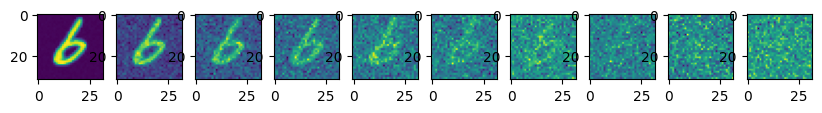

In [5]:
import matplotlib.pyplot as plt


class RandomNoise():
    def __init__(self, sample_step, device) -> None:
        self.device = device
        self.betas = torch.linspace(start=0.0001,end=0.02, steps=sample_step)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(input=self.alphas, dim=0).to(self.device)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat)
        self.alphas = self.alphas.to(self.device)
        self.betas = self.betas.to(self.device)


    @torch.no_grad()
    def apply_random_noise(self, img_tensor, step):
        noise = torch.randn_like(img_tensor, device=self.device)

        sqrt_alpha_hat = self.sqrt_alpha_hat[step][:,None,None,None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[step][:,None,None,None]
        noisy_img = sqrt_alpha_hat * img_tensor + sqrt_one_minus_alpha_hat * noise

        return noisy_img, noise

    @torch.no_grad()
    def restore_img(self, img_tensor, pred_noise, step): #step is scalar
        beta = self.betas[step]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[step]

        rest_img = torch.sqrt(1./self.alphas[step]) * (img_tensor - beta/sqrt_one_minus_alpha_hat*pred_noise)


        if 1 < step:
            noise = torch.randn_like(img_tensor, device=self.device)
        else:
            noise = torch.zeros_like(img_tensor, device=self.device)

        rest_img = rest_img + torch.sqrt(beta) * noise
        rest_img = rest_img.to(my_device)
        return rest_img

    @torch.no_grad()
    def restore_img2(self, img_tensor, pred_noise, step): #step is scalar
        beta = self.betas[step]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[step]

        rest_img = torch.sqrt(1./self.alphas[step]) * (img_tensor - beta/sqrt_one_minus_alpha_hat*pred_noise)

        if 0 < step:
            noise = torch.randn_like(img_tensor, device=self.device)
        else:
            noise = torch.zeros_like(img_tensor, device=self.device)

        rest_img = rest_img + torch.sqrt(beta*(1. - self.alpha_hat[step-1])/(1.-self.alpha_hat[step])) * noise
        return rest_img



fig, axes = plt.subplots(1, 10, figsize=(10, 1))
random_noise = RandomNoise(sample_step=SAMPLE_STEP, device='cpu')

num_images = 10
stepsize = int(SAMPLE_STEP/num_images)
images = next(iter(training_loader))[0]
sample_times = torch.linspace(start=0, end=SAMPLE_STEP-1, steps=num_images).int()


for idx in range(0,num_images):
    noisy_imgs, _ = random_noise.apply_random_noise(images,sample_times[idx][None])
    img_np = noisy_imgs[0].detach().squeeze()
    axes[idx].imshow((img_np+1)/2)
plt.show()


위 셀은 디퓨전 모델의 핵심 부분인 RandomNoise 클래스를 정의하고, 노이즈 추가 과정을 시각화합니다.

1. RandomNoise 클래스:
  * init 메소드:
    * 베타 스케줄을 정의합니다 (0.0001에서 0.02까지).
    * 알파, 알파_hat 등 디퓨전 과정에 필요한 값들을 계산합니다.
    * 모든 텐서를 지정된 디바이스로 이동시킵니다.
  * apply_random_noise 메소드:
    * 이미지에 가우시안 노이즈를 추가합니다.
    * 노이즈 추가 공식: sqrt(α_t) * x_0 + sqrt(1-α_t) * ε
    * 노이즈가 추가된 이미지와 원본 노이즈를 반환합니다.
  * restore_img 메소드:
    * 노이즈 예측을 사용하여 이미지를 복원하는 첫 번째 방법입니다.
    * DDPM(Denoising Diffusion Probabilistic Models) 논문의 알고리즘을 구현합니다.
  * restore_img2 메소드:
    * 노이즈 예측을 사용하여 이미지를 복원하는 두 번째 방법입니다.
    * DDIM(Denoising Diffusion Implicit Models) 논문의 알고리즘을 구현합니다.
2. 노이즈 적용 과정 시각화:
  * 10개의 이미지를 표시할 수 있는 서브플롯을 생성합니다.
  * RandomNoise 객체를 생성합니다.
  * 훈련 데이터로더에서 첫 번째 배치의 이미지를 가져옵니다.
  * 10개의 다른 시간 스텝에 대해 노이즈를 적용합니다.
  * 각 시간 스텝에서의 노이즈가 적용된 이미지를 시각화합니다.


이 코드는 디퓨전 모델의 노이즈 추가 및 제거 과정을 구현하고, 노이즈 추가 과정을 시각적으로 보여줍니다. 이를 통해 시간이 지남에 따라 이미지에 노이즈가 어떻게 추가되는지 확인할 수 있습니다. 이는 디퓨전 모델의 작동 원리를 이해하는 데 매우 중요합니다.

### **5. 디퓨전 모델의 훈련 과정과 이미지 생성 과정**

아래 셀은 디퓨전 모델의 훈련 과정과 이미지 생성 과정을 구현합니다
1. 모델 훈련 설정:
  * RandomNoise 객체 생성
  *	MSE 손실 함수와 Adam 옵티마이저 설정
  *	에포크 수 설정 (EPOCHS = 500)

2. 훈련 루프:
  *	각 에포크마다 데이터로더에서 배치를 가져옵니다.
  *	랜덤한 시간 스텝에서 이미지에 노이즈를 추가합니다.
  *	모델이 노이즈를 예측하도록 훈련합니다.
  *	손실을 계산하고 역전파를 수행하여 모델을 업데이트합니다.
  *	100 배치마다 현재 손실을 출력합니다.

3. 이미지 생성 및 시각화:
  *	각 에포크가 끝날 때마다 모델을 평가 모드로 전환합니다.
  *	순수한 노이즈 이미지에서 시작하여 점진적으로 노이즈를 제거합니다.
  *	노이즈 제거 과정의 10개 단계를 시각화합니다.

주요 특징:
  *	모델은 노이즈를 예측하도록 훈련됩니다. 이는 디퓨전 모델의 핵심 아이디어입니다.
  *	이미지 생성 과정에서는 노이즈에서 시작하여 점진적으로 노이즈를 제거합니다.
  *	생성된 이미지는 각 에포크마다 시각화되어 모델의 학습 진행 상황을 확인할 수 있습니다.


이 코드는 디퓨전 모델의 전체 훈련 및 생성 과정을 구현하고 있으며, 모델이 학습함에 따라 점점 더 나은 품질의 이미지를 생성할 수 있게 됩니다.



EPOCH 0
 batch0, running_loss1.1469957828521729
 batch100, running_loss0.1308018309940206
 batch200, running_loss0.10195086090199983
 batch300, running_loss0.08986104394856878
 batch400, running_loss0.08193283888541553
 batch500, running_loss0.07683076320621306
 batch600, running_loss0.07305499550556382
 batch700, running_loss0.06979978987986964
 batch800, running_loss0.06715417932835262
 batch900, running_loss0.06489479839057558


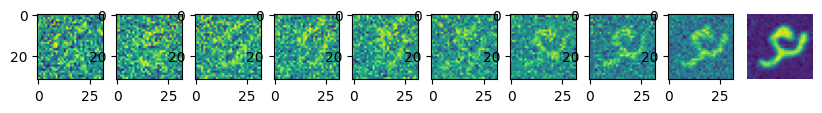

EPOCH 1
 batch0, running_loss0.03478579968214035
 batch100, running_loss0.04329393114341368
 batch200, running_loss0.04338191381067186
 batch300, running_loss0.043472943691369705
 batch400, running_loss0.04313151059472502
 batch500, running_loss0.04280988655672102
 batch600, running_loss0.04258673656081003
 batch700, running_loss0.042372218778253284
 batch800, running_loss0.04197115985474337
 batch900, running_loss0.041561251471065125


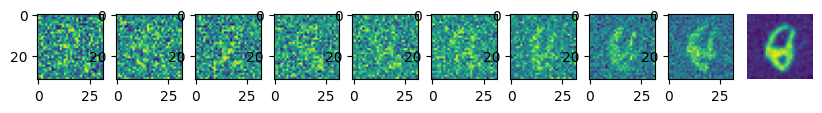

EPOCH 2
 batch0, running_loss0.04283527284860611
 batch100, running_loss0.03905439764113709
 batch200, running_loss0.0387913012849306
 batch300, running_loss0.0385742926246106
 batch400, running_loss0.038266030630268656
 batch500, running_loss0.037707385720458335
 batch600, running_loss0.03758968953694063
 batch700, running_loss0.03736796245754785
 batch800, running_loss0.037422160814503454
 batch900, running_loss0.03711245790926055


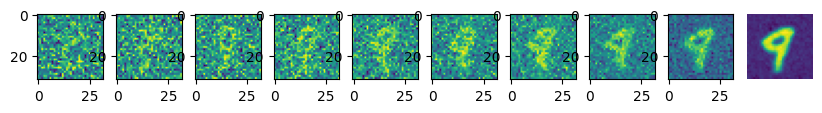

EPOCH 3
 batch0, running_loss0.03720211610198021
 batch100, running_loss0.035975106982606475
 batch200, running_loss0.036350336157489775
 batch300, running_loss0.03612882588244356
 batch400, running_loss0.0357453590282181
 batch500, running_loss0.035488079709118
 batch600, running_loss0.03533483381242106
 batch700, running_loss0.03524494579011381
 batch800, running_loss0.035227885144238316
 batch900, running_loss0.035045842866472214


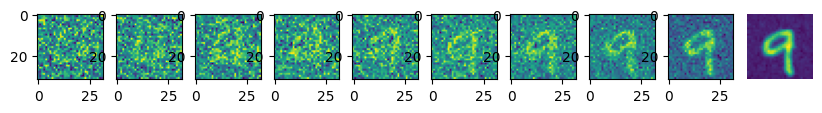

EPOCH 4
 batch0, running_loss0.029629699885845184
 batch100, running_loss0.03448586106890499
 batch200, running_loss0.03452366222604294
 batch300, running_loss0.03449461455658029
 batch400, running_loss0.03440714697643854
 batch500, running_loss0.0343084401430603
 batch600, running_loss0.03434513106991765
 batch700, running_loss0.034099672220849274
 batch800, running_loss0.03404239349802037
 batch900, running_loss0.03402696809753131


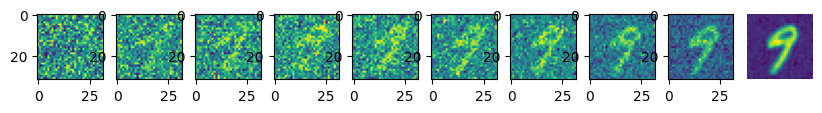

EPOCH 5
 batch0, running_loss0.03148254379630089
 batch100, running_loss0.03353854608122665
 batch200, running_loss0.03389448881964779
 batch300, running_loss0.033575690936210545
 batch400, running_loss0.0331629778251535
 batch500, running_loss0.033109667106808544
 batch600, running_loss0.0330951256699203
 batch700, running_loss0.03298902160058943
 batch800, running_loss0.03293359302886565
 batch900, running_loss0.0328607773832092


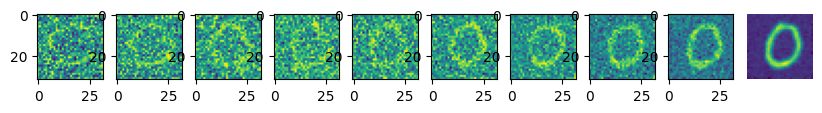

EPOCH 6
 batch0, running_loss0.03489840030670166
 batch100, running_loss0.033610351088613565
 batch200, running_loss0.03299930368304549
 batch300, running_loss0.03265167249249065
 batch400, running_loss0.032618704440067536
 batch500, running_loss0.03246797991920255
 batch600, running_loss0.03243104148401992
 batch700, running_loss0.03235797040143214
 batch800, running_loss0.032308462756068516
 batch900, running_loss0.03226114009671351


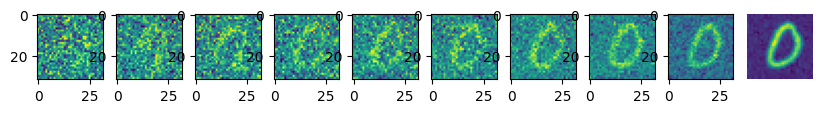

EPOCH 7
 batch0, running_loss0.03754980489611626
 batch100, running_loss0.03264738930997872
 batch200, running_loss0.03207400052886994
 batch300, running_loss0.03180474081259233
 batch400, running_loss0.03181226388493232
 batch500, running_loss0.03180314613851958
 batch600, running_loss0.03183638506852549
 batch700, running_loss0.03183418139549618
 batch800, running_loss0.03175655350823899
 batch900, running_loss0.03167236997610522


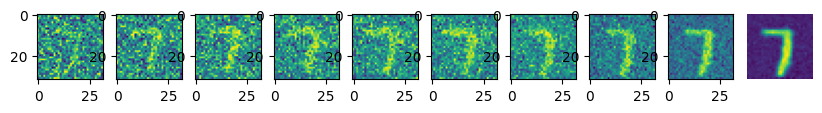

EPOCH 8
 batch0, running_loss0.026074863970279694
 batch100, running_loss0.031002309007367286


KeyboardInterrupt: 

In [7]:
random_noise = RandomNoise(sample_step=SAMPLE_STEP, device=my_device)
EPOCHS = 500

# loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch}')
    model.train()
    running_loss = 0.
    for train_idx, data in enumerate(training_loader):
        img_tensors , labels = data
        img_tensors = img_tensors.to(my_device)
        optimizer.zero_grad()
        sample_times = torch.randint(0, SAMPLE_STEP, (BATCH_SIZE,))
        noise_imgs, random_noises = random_noise.apply_random_noise(img_tensors,sample_times)

        noise_imgs = noise_imgs.to(my_device)
        random_noises = random_noises.to(my_device)
        sample_times = sample_times.to(my_device)

        noise_pred = model(noise_imgs, sample_times[:,None].float())
        loss = loss_fn(random_noises,noise_pred)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if train_idx % 100 == 0:
            print(f' batch{train_idx}, running_loss{running_loss/(train_idx+1)}')

    model.eval()
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    noise_img = torch.normal(0.0, 1.0, (1,1,32,32), device=my_device)
    plt_idx = 0
    for sample_step_int in reversed(range(0, SAMPLE_STEP)):
        sample_step = torch.tensor(sample_step_int, dtype=torch.float32, device=my_device)
        sample_step = sample_step[None,None]
        pred_noise = model(noise_img, sample_step)
        noise_img = random_noise.restore_img(noise_img, pred_noise, sample_step_int)
        noise_img = torch.clamp(noise_img, -1.0, 1.0)

        if sample_step % (SAMPLE_STEP/10) == 1:
            noise_img_clamp = torch.clamp(noise_img, -1.0, 1.0)
            noise_img_np = noise_img_clamp.detach().squeeze().to('cpu').numpy()
            axes[plt_idx].imshow((noise_img_np+1)/2)
            plt_idx = plt_idx+1
    plt.axis('off')  # To hide axis
    plt.show()
    # break

